In [1]:
from pyiron_workflow import Workflow
from typing import Optional

In [2]:
from python.pyironflow import PyironFlow
import pyiron_nodes.continuum_fem.geometries as pnf_geom
import pyiron_nodes.continuum_fem.function_spaces as pnf_func
import pyiron_nodes.continuum_fem.mesh_visualization as pnf_viz
import pyiron_nodes.continuum_fem.boundary_conditions as pnf_bc
import pyiron_nodes.continuum_fem.load_definitions as pnf_load
import pyiron_nodes.continuum_fem.solvers as pnf_solve
import pyiron_nodes.continuum_fem.custom_nodes as pnf_custom
import pyiron_nodes.atomistic.engine as pna_eng
import pyiron_nodes.atomistic.structure as pna_struct
import pyiron_nodes.atomistic.property as pna_prop
import pyiron_nodes.large_scale_atomistic.structure as pnl_struct

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.000683181s, CPU 0.000799s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 20%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 5 (Plane, Frontal-Delaunay)
Info    : [ 90%

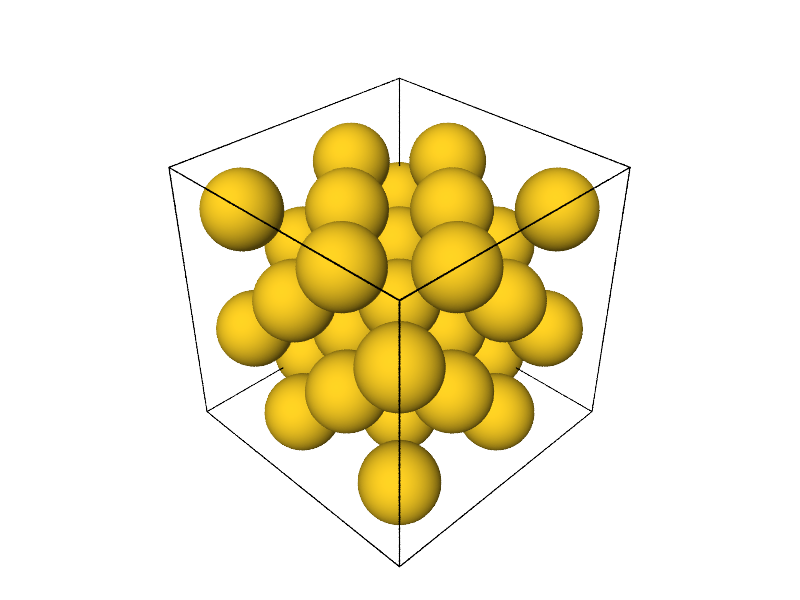

[[ 2.00224187e+02  1.50926574e+02  1.25868031e+02  0.00000000e+00
  -3.89089971e-15  0.00000000e+00]
 [ 1.50926574e+02  1.75165644e+02  1.50926574e+02  0.00000000e+00
  -2.54536099e-15  0.00000000e+00]
 [ 1.25868031e+02  1.50926574e+02  2.00224187e+02  0.00000000e+00
  -3.89089971e-15  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.71780777e+01
   0.00000000e+00 -1.11376737e-15]
 [-3.12189556e-15 -2.54536099e-15 -3.12189556e-15  0.00000000e+00
   1.21195353e+01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11376737e-15
   0.00000000e+00  3.71780777e+01]]


{'visualize_atoms__image': None,
 'init_mesh_plotter_obj__plotter': <pyvista.plotting.plotter.Plotter at 0x777304de0e90>,
 'vonMises_plotter_obj__plotter': <pyvista.plotting.plotter.Plotter at 0x7772def33490>}

In [3]:
wf = Workflow("multiscale_linear_elasticity")

#----------------------------------------------------------------------------------------------------------------------------------------
# atomistic part
wf.ase_emt_engine = pna_eng.ase.EMT()

wf.structure = pna_struct.build.CubicBulkCell(element="Au", cell_size = 2)

wf.elastic_calc_params = pna_prop.elastic.InputElasticTensor(num_of_point=7, eps_range=0.005, sqrt_eta=True, fit_order=3)

wf.elastic_constants = pna_prop.elastic.ElasticConstants(wf.structure, wf.ase_emt_engine, wf.elastic_calc_params)

wf.rotated_elastic_tensor = pna_prop.elastic.RotateElasticityTensor(wf.elastic_constants, crystal="fcc", 
                                                                      x_indices="0 -1 1", y_indices="1 0 0", z_indices="0 1 1")

wf.visualize_atoms = pnl_struct.visualize_structures.Ase2OvitoTachyonRenderPersp(structure=wf.structure)

#----------------------------------------------------------------------------------------------------------------------------------------
# FEM part
wf.bar_geom_params = pnf_geom.three_d_geometries.BarParameters(length=0.6, width=0.04, depth=0.04, density=1.0)

wf.bar_domain = pnf_geom.three_d_geometries.Bar(x0=0, y0=0, z0=0, min_mesh=0.01, max_mesh=0.01, parameters=wf.bar_geom_params)

wf.vector_function_space = pnf_func.general_function_spaces.VectorFunctionSpace(wf.bar_domain, "Lagrange", 2)

wf.init_mesh_plotter_obj= pnf_viz.pyvista_viz.PlotInitMeshObject(wf.vector_function_space)

wf.bc_left = pnf_bc.scalar_geometric.ScalarDirichlet3D(function_space=wf.vector_function_space, bc_function="np.isclose(x[0], 0)",
                                                       value_x=0, value_y=0, value_z=0
                                                      )

wf.bc_right = pnf_bc.scalar_geometric.ScalarDirichlet3D(function_space=wf.vector_function_space, bc_function="np.isclose(x[0], 0.6)",
                                                        value_x=0, value_y=0, value_z=0
                                                       )
wf.bc_array = pnf_bc.scalar_geometric.CollectBcs(bc1=wf.bc_left, bc2=wf.bc_right)

wf.solution_vector = pnf_solve.linear_elasticity.LinearElasticity3D(domain=wf.bar_domain, function_space=wf.vector_function_space,
                                                                    bcs_array=wf.bc_array, traction_x=0, traction_y=0.0006, 
                                                                    traction_z=-0, body_force_x=0, body_force_y=0, body_force_z=0, 
                                                                    gravity_factor=10, elasticity_tensor=wf.rotated_elastic_tensor,
                                                                    parameters=wf.bar_geom_params
                                                                   )

wf.vonMises_plotter_obj = pnf_viz.pyvista_viz.PlotVonMises3DObject(domain=wf.bar_domain,
                                                                   function_space=wf.vector_function_space,
                                                                   solution_vector=wf.solution_vector,
                                                                   elasticity_tensor=wf.rotated_elastic_tensor, 
                                                                   warp_factor=20.0                                                                                         
                                                                  )

#----------------------------------------------------------------------------------------------------------------------------------------

wf()

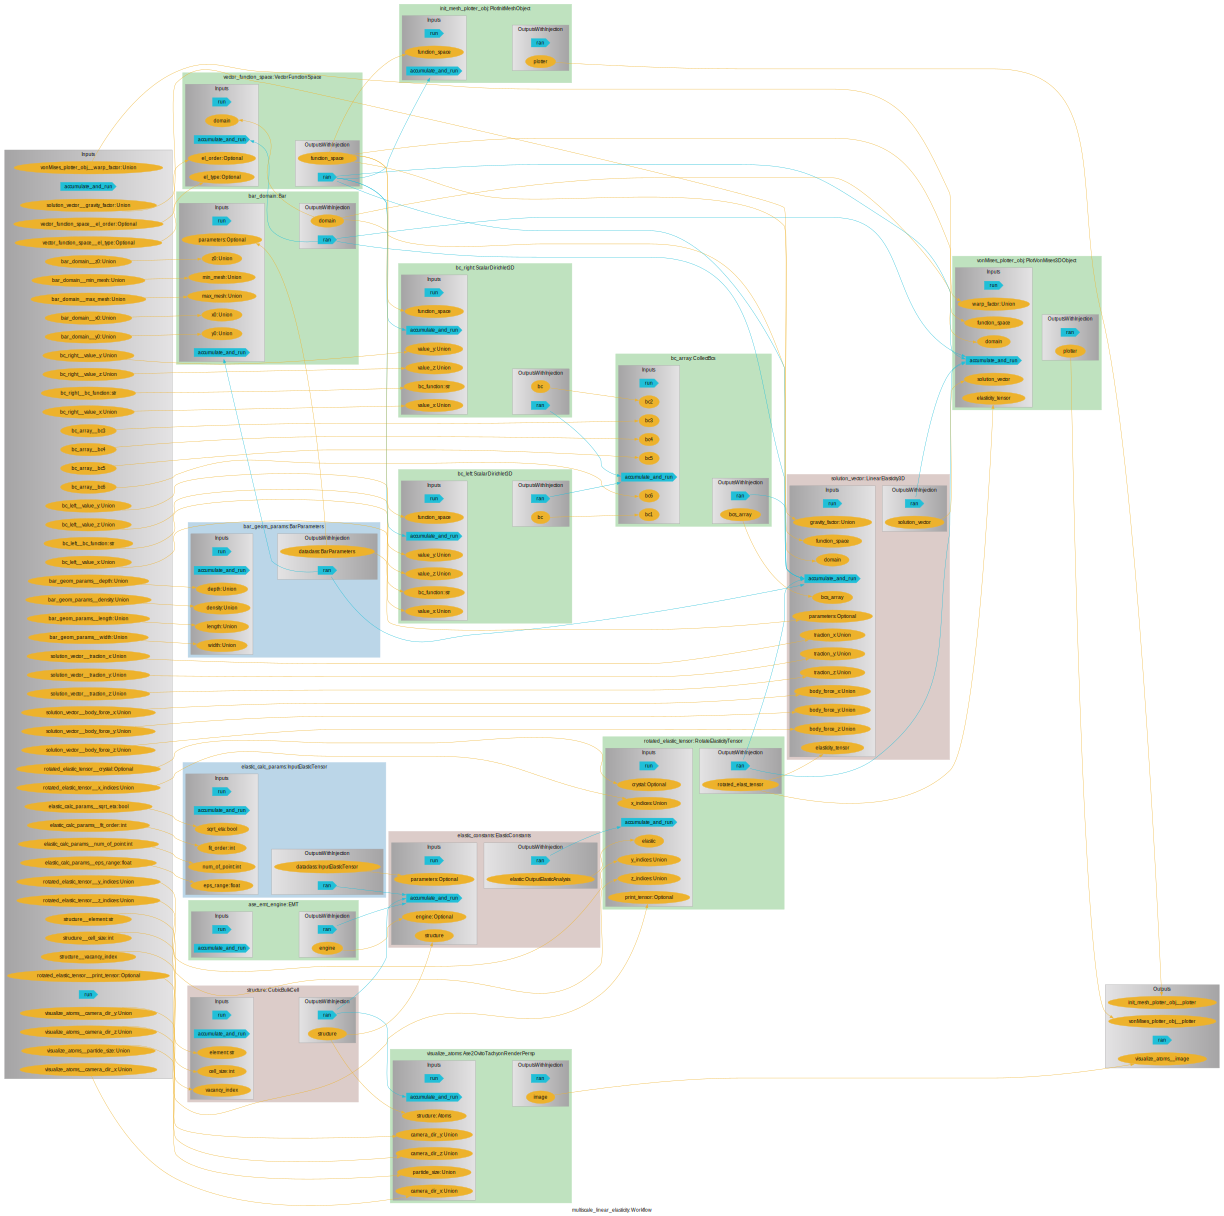

In [4]:
wf.draw(size=(17,17))
#pic = wf.draw(size=(15,15))
#pic.render(outfile='workflow.svg')

In [5]:
pf = PyironFlow([wf])
#pf = PyironFlow()
pf.gui

In [6]:
#pf.display_workflow(0)

In [6]:
wf_from_gui = pf.get_workflow()

In [7]:
wf_from_gui.init_mesh_plotter_obj.pull().show()

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0,000723116s, CPU 0,001043s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 20%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 5 (Plane, Frontal-Delaunay)
Info    : [ 90%

Widget(value='<iframe src="http://localhost:46123/index.html?ui=P_0x7772defa9150_3&reconnect=auto" class="pyvi…

In [10]:
wf_from_gui.vonMises_plotter_obj.pull().show()

A view with name (P_0x7772dc724c90_5) is already registered
 => returning previous one


Widget(value='<iframe src="http://localhost:46123/index.html?ui=P_0x7772dc724c90_5&reconnect=auto" class="pyvi…

In [9]:
tmp = wf_from_gui.vector_function_space.pull()
tmp

FunctionSpace(Mesh(blocked element (Basix element (P, tetrahedron, 1, equispaced, unset, False, float64, []), (3,)), 1), blocked element (Basix element (P, tetrahedron, 2, gll_warped, unset, False, float64, []), (3,)))